<a href="https://colab.research.google.com/github/fxop0218/Tutorial-PyTorchForBeginners/blob/main/05_custom_dataset_pytorch_beginners.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Custom Dataset to Beginners

## 1. Import // setting device-agnostic

In [200]:
import torch # PyTorch 1.10.0 + required
from torch import nn

print(f"Torch version: {torch.__version__}")

Torch version: 1.13.1+cu116


In [201]:
# Setup device-agnostic
device = "cuda" if torch.cuda.is_available() else "cuda"
print(f"Device: {device}")

Device: cuda


## 2. Get data

**🟦ES**: Our dataset in a subset of the Food101 dataset

Food101 starts 101 different classes of food and 1000 images per class (75% training and 25% testing) 

Our dataset starts with 3 classes of food and only 10% of the images.

When startitng out ML model, it's important to try things on a small scale and then increase the sacle when necessary.

The whole point is to speed up how fast you can experiment.

**🟥EN**: Nuestro conjunto de datos en un subconjunto del conjunto de datos Food101

Food101 comienza con 101 clases diferentes de alimentos y 1000 imágenes por clase (75% de entrenamiento y 25% de prueba) 

Nuestro conjunto de datos comienza con 3 clases de alimentos y sólo el 10% de las imágenes.

Cuando se inicia un modelo ML, es importante probar las cosas a pequeña escala y luego aumentar el saco cuando sea necesario.

El objetivo es acelerar la velocidad de experimentación.

 

In [202]:
import requests 
import zipfile
from pathlib import Path

# Startup patht to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"
ZIP_FILE = "pizza_steak_sushi.zip"

In [203]:
# Download only if the image folder exists
if image_path.is_dir():
  print(f"The directory {image_path} already exists...")
else:
  print(f"The directory {image_path} does not exists...")
  image_path.mkdir(parents=True, exist_ok=True)

The directory data/pizza_steak_sushi already exists...


In [204]:
# Download

with open(data_path / ZIP_FILE, "wb") as f:
  request = requests.get("https://github.com/mahdiislam79/Pizza_steak_sushi_prediction_Pytorch/raw/main/data/pizza_steak_sushi.zip")
  f.write(request.content)

with zipfile.ZipFile(data_path / ZIP_FILE, "r") as f:
  f.extractall(image_path)
  print(f"Extracted correctly {ZIP_FILE} into {image_path}")


Extracted correctly pizza_steak_sushi.zip into data/pizza_steak_sushi


## 3. Data modification

In [205]:
import os
def to_dir(directory_path):
  for dirpath, dirnames, filenames in os.walk(directory_path):
    print(f"Number of directories  {len(dirnames)} || Number of images {len(filenames)} in {dirpath}")

In [206]:
to_dir(image_path)

Number of directories  2 || Number of images 0 in data/pizza_steak_sushi
Number of directories  3 || Number of images 0 in data/pizza_steak_sushi/test
Number of directories  0 || Number of images 19 in data/pizza_steak_sushi/test/steak
Number of directories  0 || Number of images 25 in data/pizza_steak_sushi/test/pizza
Number of directories  0 || Number of images 31 in data/pizza_steak_sushi/test/sushi
Number of directories  3 || Number of images 0 in data/pizza_steak_sushi/train
Number of directories  0 || Number of images 75 in data/pizza_steak_sushi/train/steak
Number of directories  0 || Number of images 78 in data/pizza_steak_sushi/train/pizza
Number of directories  0 || Number of images 72 in data/pizza_steak_sushi/train/sushi


In [207]:
train_dir = image_path / "train"
test_dir = image_path / "test"

### 3.1 Visualizing data

**🟦EN**:
1. Get all the paths of the images.
2. Pick random image.
3. Get image with their class name. 
4. Open images with Python PIL.
5. We'll then show the image and print metadata.
**🟥ES**:
1. Conseguir todos los directorios de las imagenes. 
2. Coger una imagen random
3. Coger imagenes con su classe
4. Abrir las imagener con Python PIL
5. Mostrar el Metadata de la imagen

In [208]:
from PIL import Image
import random

# Seed
random.seed(10)

# Get paths
image_list = list(image_path.glob("*/*/*.jpg"))

# Pick random image
rand_img = random.choice(image_list)
print(f"Random image directory: {rand_img}")

# Get image class from path, in this case, the class is the folder that contains the image
img_class = rand_img.parent.stem
print(f"Class: {img_class}")

# Open img
img = Image.open(rand_img)

Random image directory: data/pizza_steak_sushi/train/sushi/1575445.jpg
Class: sushi


Image path: data/pizza_steak_sushi/train/sushi/1575445.jpg
Class: sushi
Height: 307 Width: 512


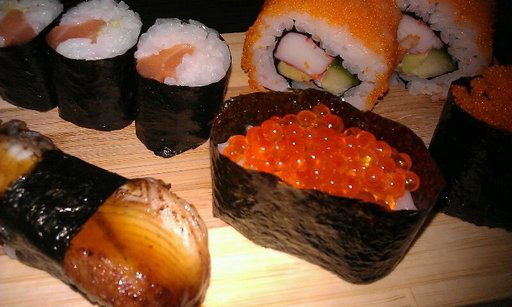

In [209]:
print(f"Image path: {rand_img}\nClass: {img_class}\nHeight: {img.height} Width: {img.width}")
img

Image shape: (307, 512, 3)


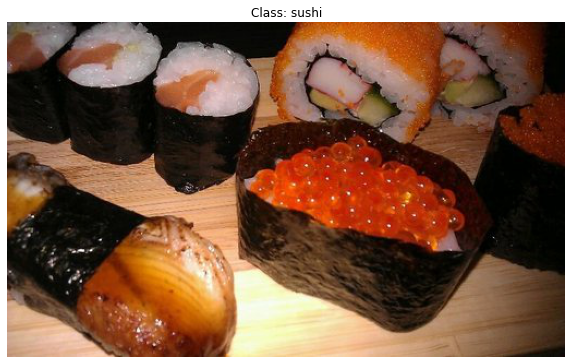

In [210]:
import matplotlib.pyplot as plt
import numpy as np

# Image => Array
img_array = np.asarray(img)

# Plot img
plt.figure(figsize=(10, 10))
plt.imshow(img_array)
plt.title(f"Class: {img_class}")
plt.axis(False)

print(f"Image shape: {img_array.shape}")

## 4. Data manipulation

**🟦EN**: Before we can use image data with PyTorch
1. Turn target data into tensors
2. Turn it into a `torch.utils.data.Dataset` as subsequently a `torch.utils.data.DataLoader`

**🟥ES**:


In [211]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transform img with `torchvision.transform`

**🟦EN**: Transform data is required to use with a model

**🟥ES**: La transformación de datos es necesaria para su uso con un modelo


In [212]:
img_transform = transforms.Compose([
    # Resize img to (x, y) in this case x, y = 64
    transforms.Resize(size=(64, 64)),
    # Flip image randomly
    transforms.RandomHorizontalFlip(p=0.5),
    # Image => torch.Tensor
    transforms.ToTensor(),
])

In [213]:
img_t = img_transform(img)
print(f"Image shape: {img_t.shape} [color_channel, height, width]")

Image shape: torch.Size([3, 64, 64]) [color_channel, height, width]


In [214]:
def plot_transformed_images(image_paths, transform, n=6, seed=10):

  # Put random seed if exists
  if seed:
    random.seed(seed)
  rand_img = random.sample(image_paths, k=n)

  for image_path in rand_img:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Non Modified Size: {f.size}")
      ax[0].axis(False)

      # Transform and plto to see the diff
      trans_img = transform(f).permute(1, 2, 0) # (C, H, W)
      ax[1].imshow(trans_img)
      ax[1].set_title(f"Modified Size: {trans_img.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=20)

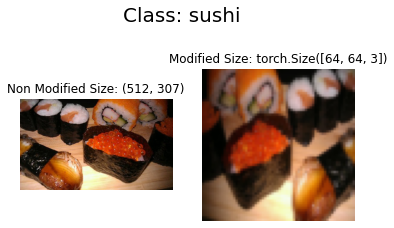

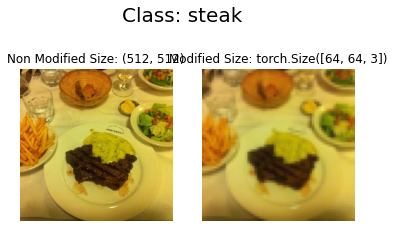

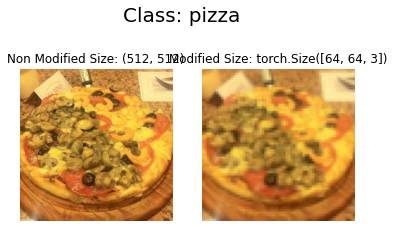

In [215]:
plot_transformed_images(image_paths=image_list,
                        transform=img_transform,
                        n=3,
                        seed=10)

## 4. Option 1: Loading image data using `ImageFolder`

**🟦EN**: We can load image classification data using `torchvision.dataset.ImageFolder`

**🟥ES**: Podemos cargar imagenes de classificación usando `torchvision.dataset.ImageFolder`


In [216]:
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=img_transform, # Transform from the data
                                  target_transform=None) # A transform for the label / target

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=img_transform)

print(f"Train data\n#############\n{train_data}\n-------------------\nTest data\n#############\n{test_data}")                           

Train data
#############
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
-------------------
Test data
#############
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [217]:
# Class name as list
classes = train_data.classes
print(f"All classes: {classes}")

All classes: ['pizza', 'steak', 'sushi']


In [218]:
# Classes dict
classes_dict = train_data.class_to_idx
print(f"Classes dict: {classes_dict}")

Classes dict: {'pizza': 0, 'steak': 1, 'sushi': 2}


In [219]:
# train_data.targets ==> Show all labels
train_data.samples[:5]

[('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1033251.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1044789.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1089334.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1105700.jpg', 0)]

In [220]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}\n\nImage shape: {img.shape}\nImage DType: {img.dtype}\n")
print(f"Label: {label}\nLable DType: {type(label)}")

Image tensor:
tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0863],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0706],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0196,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.09

In [221]:
permuted_img = img.permute(1, 2, 0)

# Print different shapes
print(f"Not modified shape: {img.shape} [color_channel, height, width]")
print(f"Permuted image: {permuted_img.shape} [height, width, color_channel]")

Not modified shape: torch.Size([3, 64, 64]) [color_channel, height, width]
Permuted image: torch.Size([64, 64, 3]) [height, width, color_channel]


(-0.5, 63.5, 63.5, -0.5)

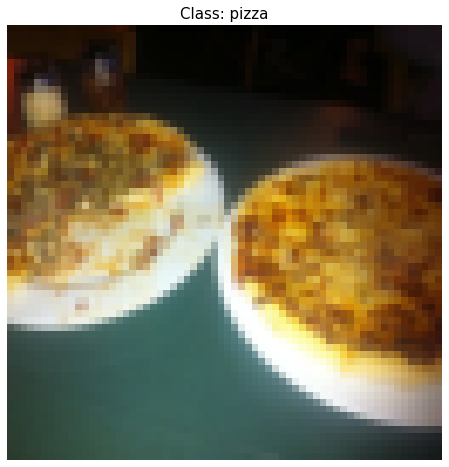

In [222]:
# Plot img
plt.figure(figsize=(8, 8))
plt.imshow(permuted_img)
plt.title(f"Class: {classes[label]}", fontsize=15)
plt.axis("off")

### 5.1 Turn loaded image into `DataLoader`

**🟦EN**: `DataLoader` is going to help us turn out `Dataset` into iterables and we can customise the `batch_size` so our model can see `batch_size` images at time

**🟥ES**:

In [223]:
# Train / test datasets => DataLoader
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)

print(f"Train dataloader length: {len(train_dataloader)} || Test_dataloader length: {len(test_dataloader)}\nWith batch size of {BATCH_SIZE}")

Train dataloader length: 8 || Test_dataloader length: 3
With batch size of 32


## 6 Option 2: Load image with custom dataset
**🟦EN**:
1. Want to be able to load image from files
2. Want to be able to get class names from dataset
3. Want to be able to get classes as dictionary from dataset

*Pros*:
* Can create a `dataset` out of almost anything
* Not limited to PyTorch prebuild `Dataset`functions

*Cons*:
* Even though you could create `Dataset` out of almost anything, it doesn't mean it will work
* Using custom `Datasat`often results in us writing more code, which could be prone to errors or performance issues. 

**🟥ES**:
1. Quiero ser capaz de cargar la imagen de los archivos
2. Desea poder obtener los nombres de las clases del conjunto de datos
3. Quiero ser capaz de obtener las clases como diccionario de conjunto de datos

*Pros
* Puede crear un `dataset` de casi cualquier cosa
* No está limitado a las funciones precompiladas de PyTorch.

*Desventajas
* Aunque puedas crear un `Dataset` a partir de casi cualquier cosa, no significa que funcione.
* Usar `Datasat` personalizados a menudo nos obliga a escribir más código, que puede ser propenso a errores o problemas de rendimiento. 


In [224]:
import os
import torch
import pathlib

from PIL import Image
from torchvision import transforms
from typing import Tuple, Dict, List
from torch.utils.data import Dataset

In [225]:
# Instance of torchvision.datasets.ImageFolder()
print(f"Traind data classes:{train_data.classes}\n\nDictionary data classes: {train_data.class_to_idx}")

Traind data classes:['pizza', 'steak', 'sushi']

Dictionary data classes: {'pizza': 0, 'steak': 1, 'sushi': 2}


### 6.1 Helper function to get class names

**🟦EN**:
1. Get class names with `os.scandir()` to travese a target directory 
2. Classes name => Dict and list and return
3. If the class name aren't found, raise a error.
**🟥ES**:
1. Obtener los nombres de las clases con `os.scandir()` para recorrer un directorio de destino 
2. Nombre de clases => Dict y lista y devuelve
3. Si el nombre de la clase no se encuentra, genera un error.


In [226]:
# Setup path
target_dir = train_dir
print(f"Target dir: {target_dir}")

# Get the class names
class_names_found = sorted([entry.name for entry in list(os.scandir(target_dir))])
print(f"Class names dir found: {class_names_found}")

Target dir: data/pizza_steak_sushi/train
Class names dir found: ['pizza', 'steak', 'sushi']


In [227]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  # Get class
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # Error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"No classe found in {directory}")

  # Create dict (optim numbers than strings)
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
  return classes, class_to_idx

In [228]:
find_classes(target_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 6.2 Create ña custom `Dataset` to replace `ImageFolder`

**🟦EN**: Create custom dataset:
1. Subclass `torch.utils.data.Dataset`
2. Init our subcalss with a target dirrectory as wekk as a transform if we'd like to transform our data.
3. Create several attributes:
  * paths => paths of out images.
  * transform => the transform we'd like to use.
  * classes => a list of the target classes.
  * class_to_idx => a dict of the target classes mapped to integer labels.
4. Create `load_imgs()` function, this function will open a image.
5. Overwrite the `__len()__` method to return the length of out dataset
6. Overwirte the `__getitem()__` method to return a given sample when àsses an index

**🟥ES**: Crear un conjunto de datos personalizado:
1. Subclase `torch.utils.data.Dataset`
2. 2. Iniciamos nuestro subcálculo con un directorio de destino y un transform si queremos transformar nuestros datos.
3. Crear varios atributos:
  * paths => rutas de nuestras imágenes.
  * transform => la transformación que queremos usar.
  * classes => una lista de las clases de destino.
  * class_to_idx => un dict de las clases objetivo mapeadas a etiquetas enteras.
4. Crear la función `load_imgs()`, esta función abrirá una imagen.
5. Sobrescribir el método `__len()__` para devolver la longitud del conjunto de datos.
6. Sobreescriba el método `__getitem()__` para devolver una muestra dada cuando àsses un índice



In [229]:
# Custom dataset
from torch.utils.data import Dataset

# Subclass target.utils.data.Dataset
class ImageFolderCustom(Dataset):
  # Init custom dataset
  def __init__(self, target_dir: str, transform=None):
    # Get all img paths
    self.paths = list(pathlib.Path(target_dir).glob("*/*.jpg"))
    self.transform = transform
    # Classes 
    self.classes, self.classes_idx = find_classes(target_dir)

  # Load img function
  def load_img(self, index: int) -> Image.Image:
    img_path = self.paths[index]
    return Image.open(img_path)

  
  # Overwrite __len__()
  def __len__(self) -> int:
    return len(self.paths)

  # Overwrite __getitem__() method to return particular sample
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    img = self.load_img(index)
    class_name = self.paths[index].parent.name
    class_id = self.classes_idx[class_name]

    # transform
    if self.transform:
      return self.transform(img), class_id # Return img data and class id
    else:
      return img, class_id # Return untransformed image and label

In [230]:
from torchvision import transforms
# Transformers
train_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.ToTensor(),
    
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor(),
])

In [231]:
train_data_custom = ImageFolderCustom(target_dir=train_dir,
                                      transform=train_transforms)

test_data_custom  = ImageFolderCustom(target_dir=test_dir,
                                      transform=test_transforms)

In [232]:
print(f"Train data custom:\n{train_data_custom}\n\nTest data custom:\n{test_data_custom}\n\n")
print(f"Train data custom length:{len(train_data_custom)}\nTest data custom: {len(test_data_custom)}")
print(f"Data custom classes: {train_data_custom.classes}")
print(f"Data custom classes index: {train_data_custom.classes_idx}")

Train data custom:

Test data custom:


Train data custom length:225
Test data custom: 75
Data custom classes: ['pizza', 'steak', 'sushi']
Data custom classes index: {'pizza': 0, 'steak': 1, 'sushi': 2}


### 6.3 Display random imgs

**🟦EN**:
1. Take it a `DataSet` and a number of other parametes such as class names and how many iamges to viualize
2. To prevent the display getting out of hand, let's cap th enumber of iamges to see 10
3. Set a random seed for reproducibility
4. Get a list of random samples indexes from the target dataset.
5. Setup matplotlib plot
6. Loop through the random sample images and plot them with plt
7. Make sure the dimensions of out images lines up with matplotlib

**🟥ES**:
1. Tomar un `DataSet` y una serie de otros parámetros como los nombres de clase y cuántos iamges para viualizar
2. Para evitar que la visualización se nos vaya de las manos, vamos a limitar el número de iamges a 10.
3. Establecer una semilla aleatoria para la reproducibilidad
4. Obtenga una lista de índices de muestras aleatorias del conjunto de datos de destino.
5. Configurar el gráfico matplotlib
6. Recorrer las imágenes de las muestras aleatorias y trazarlas con plt
7. Asegúrese de que las dimensiones de las imágenes se alinean con matplotlib




In [233]:
# Create function take
def disp_rand_imgs(dataset: torch.utils.data.Dataset,
                   display_shape: bool = True,
                   classes: List[str] = None,
                   seed: int = None,
                   n: int = 9):
  if n > 9:
    n = 9
    disp_shape = False
    print(f"Max display: {n}")
  
  # Set seed if exists
  if seed:
    random.seed(seed)

  # Get random index
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  # Loop through random indexes and plot them with matplotlib
  plt.figure(figsize=(20, 10))
  for i, target_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[target_sample][0], dataset[target_sample][1]

    # Adjust tensro dim (matplotlib needs [height, width, color_channel] and now is [color_channel, height, width])
    adjusted_img = targ_image.permute(1, 2, 0)
    
    # Plot adjusted images
    plt.subplot(1, n, i+1)
    plt.imshow(adjusted_img)
    plt.axis("off")
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nShape: {adjusted_img.shape}"
    plt.title(title)

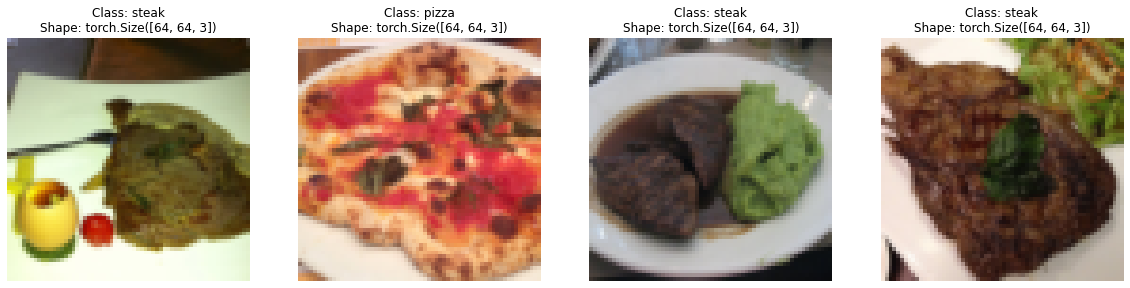

In [234]:
disp_rand_imgs(dataset=train_data,
               classes=classes,
               seed=10,
               n=4)

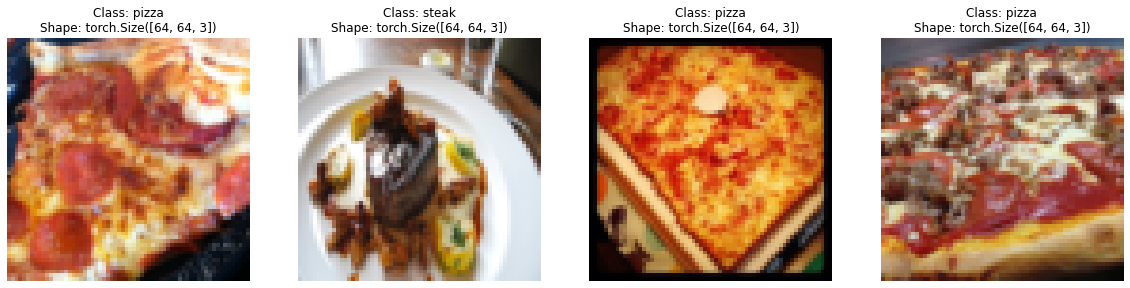

In [235]:
disp_rand_imgs(dataset=train_data_custom,
               classes=classes,
               seed=10,
               n=4)

### 6.4 Custom loaded images into `DataLoader`'s

In [236]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
N_WORKERS = os.cpu_count()
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=N_WORKERS,
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data,
                                    batch_size=BATCH_SIZE,
                                    num_workers=N_WORKERS)

In [237]:
# Image, label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Print out the shapes 
print(f"Image custom shape: {img_custom.shape}, Label custom shape: {label_custom.shape}")

Image custom shape: torch.Size([32, 3, 64, 64]), Label custom shape: torch.Size([32])


## 7 More ways to transformation

Data Argumentation is the process od artificially adding diversity to your training data. 

In the case of image data, this may applying various iamge transformation to training images. 

Let's take a look at one particular type of data augmentation used to tain PyTorch vision model to state of the art

https://pytorch.org/vision/stable/transforms.html
https://pytorch.org/vision/master/generated/torchvision.transforms.TrivialAugmentWide.html

In [238]:
from torchvision import transforms

train_transforms = transforms.Compose([transforms.Resize(size=(224, 224)),
                                       transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                       transforms.ToTensor()])

test_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()])

In [239]:
 # All image paths 
 image_path_list = list(image_path.glob("*/*/*.jpg"))
 image_path_list[:5]

[PosixPath('data/pizza_steak_sushi/test/steak/690177.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/502076.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/2117351.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/100274.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1016217.jpg')]

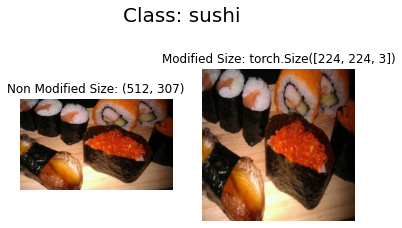

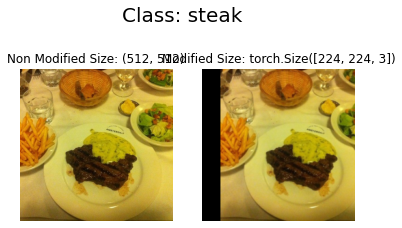

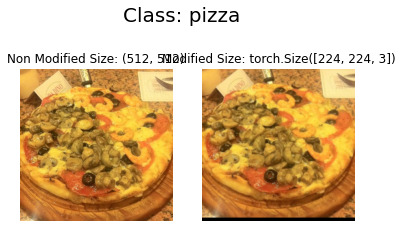

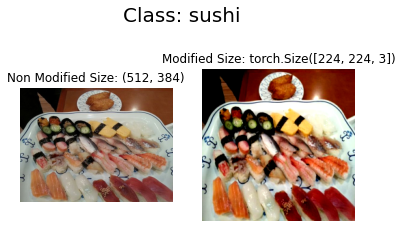

In [240]:
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transforms,
    n=4,
    seed=10
)

## 8. TiniVGG without data augmentation

### 8.1 Transform and loading data Model 0

In [241]:
# Create simple transform

simple_trans = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor(),
])

In [242]:
# Load transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir,
                                        transform=simple_trans)

test_data_simple = datasets.ImageFolder(root=train_dir,
                                        transform=simple_trans)

# Create DataLoaders
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=N_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=N_WORKERS)

### 8.2 Create TinyVGG Model class

In [243]:
class TinyVGG_v1(nn.Module):
  def __init__(self, input_shape: int, output_shape: int, hidden_lay: int):
    super().__init__()
    self.conv_layer1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_lay,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_lay,
                  out_channels=hidden_lay,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)

    )

    self.conv_layer2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_lay,
                  out_channels=hidden_lay,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_lay,
                  out_channels=hidden_lay,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)

    )
  
    self.classifier = nn.Sequential(
        nn.Flatten(), 
        nn.Linear(in_features=hidden_lay*13*13,
                  out_features=output_shape)
    )
  def forward(self, x):
    x = self.conv_layer1(x)
    # print(f"Conv1 shpae: {x.shape}")
    x = self.conv_layer2(x)
    # print(f"Conv1 shpae: {x.shape}")
    return self.classifier(x)

In [244]:
torch.manual_seed(10)

model_v1 = TinyVGG_v1(input_shape=3,
                   hidden_lay=10,
                   output_shape=len(classes)).to(device)

model_v1

TinyVGG_v1(
  (conv_layer1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 8.3 Try forward pass on a single image

In [245]:
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [246]:
model_v1(image_batch.to(device))

tensor([[0.0536, 0.0287, 0.0470],
        [0.0564, 0.0236, 0.0409],
        [0.0547, 0.0259, 0.0459],
        [0.0554, 0.0236, 0.0297],
        [0.0593, 0.0230, 0.0379],
        [0.0548, 0.0156, 0.0411],
        [0.0640, 0.0269, 0.0267],
        [0.0538, 0.0193, 0.0380],
        [0.0586, 0.0237, 0.0286],
        [0.0523, 0.0247, 0.0320],
        [0.0573, 0.0219, 0.0400],
        [0.0563, 0.0201, 0.0407],
        [0.0509, 0.0218, 0.0380],
        [0.0543, 0.0279, 0.0413],
        [0.0641, 0.0287, 0.0383],
        [0.0540, 0.0209, 0.0408],
        [0.0579, 0.0289, 0.0380],
        [0.0530, 0.0234, 0.0434],
        [0.0526, 0.0288, 0.0489],
        [0.0541, 0.0168, 0.0390],
        [0.0547, 0.0186, 0.0297],
        [0.0572, 0.0301, 0.0333],
        [0.0529, 0.0311, 0.0284],
        [0.0537, 0.0252, 0.0448],
        [0.0562, 0.0217, 0.0344],
        [0.0573, 0.0199, 0.0357],
        [0.0542, 0.0172, 0.0385],
        [0.0573, 0.0231, 0.0324],
        [0.0529, 0.0331, 0.0477],
        [0.055

In [247]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_v1, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG_v1                               [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

# 8.5 Train / test function

In [248]:
def train_step(model: torch.nn.Module,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               dataloader: torch.utils.data.DataLoader,
               device: torch.device = device):

  # print(f"Train step deployed in: {device}")

  # Train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss = 0
  train_acc = 0
  for batch, (X, y) in enumerate(dataloader):
    X = X.to(device)
    y = y.to(device)

    # Forward pass
    y_pred = model(X)

    # Calculate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # Optimizer step
    optimizer.zero_grad()
    loss.backward()

    # Calculate accuracy metric
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred) # Accuracy formula

  # Adjust metrics
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc


In [249]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device = device):
  
  # Evalutaion mode
  model.eval()

  test_loss = 0
  test_acc = 0
  
  # Inference mode
  with torch.inference_mode():
    # Loop through DataLoader
    for batch, (X, y) in enumerate(dataloader):
      # Send data to the target device
      X = X.to(device)
      y = y.to(device)

      # forward pass
      test_pred_logits = model(X)

      # Calculate loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  test_loss = test_loss/len(dataloader)
  test_acc = test_acc/len(dataloader)
  return test_loss, test_acc



### 8.6 Creating train funtion to combien `train_step()` and `test_step()`

In [250]:
from tqdm.auto import tqdm

# Create train function that takes in varios models parametes
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 6, device: torch.device = device):
  
  # Create empty result dictionary
  results = {"train_loss" : [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)

    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn) 
    
  # Print inf
    print(f"Epochs: {epoch} | Train loss: {train_loss:.6f} | Train acc: {train_acc:.6f} | Test loss: {test_loss:.4f}")

    # Update results
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

### 8.7 Train and evaluate model

In [251]:
# Random seed
torch.manual_seed(10)
torch.cuda.manual_seed(10)

# Set Epochs
NUM_EPOCHS = 6/

# Recreate TinyVGG
model_v1 = TinyVGG_v1(input_shape=3,
                   hidden_lay=10,
                   output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_v1.parameters(),
                             lr=0.003)

In [252]:
# Start timer
from timeit import default_timer as timer
start_training_time = timer()

model_v1_res = train(model=model_v1,
                     train_dataloader=train_dataloader_simple,
                     test_dataloader=test_dataloader_simple,
                     optimizer=optimizer,
                     loss_fn=loss_fn,
                     epochs=NUM_EPOCHS)

finish_training_time = timer()

print(f"Total training time: {finish_training_time - start_training_time}")

  0%|          | 0/6 [00:00<?, ?it/s]

Epochs: 0 | Train loss: 1.097797 | Train acc: 0.429688 | Test loss: 1.1002
Epochs: 1 | Train loss: 1.100171 | Train acc: 0.308594 | Test loss: 1.1002
Epochs: 2 | Train loss: 1.100224 | Train acc: 0.308594 | Test loss: 1.1002
Epochs: 3 | Train loss: 1.100977 | Train acc: 0.308594 | Test loss: 1.1002
Epochs: 4 | Train loss: 1.101460 | Train acc: 0.308594 | Test loss: 1.1002
Epochs: 5 | Train loss: 1.101438 | Train acc: 0.308594 | Test loss: 1.1002
Total training time: 13.556022384000244


In [253]:
def plot_loss_curves(res: Dict[str, List[float]]):
  loss = res["train_loss"]
  test_loss = res["test_loss"]

  acc = res["train_acc"]
  test_acc = res["test_acc"]

  epochs = range(len(res["train_loss"]))

  # Plot
  plt.figure(figsize=(16, 8))

  # Loss plot
  plt.subplot(1, 2, 1)
  plt.title("Loss curve")
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()

  # Acc plot
  plt.subplot(1, 2, 2)
  plt.title("Accuracy curve")
  plt.plot(epochs, acc, label="train_acc")
  plt.plot(epochs, test_acc, label="test_acc")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()


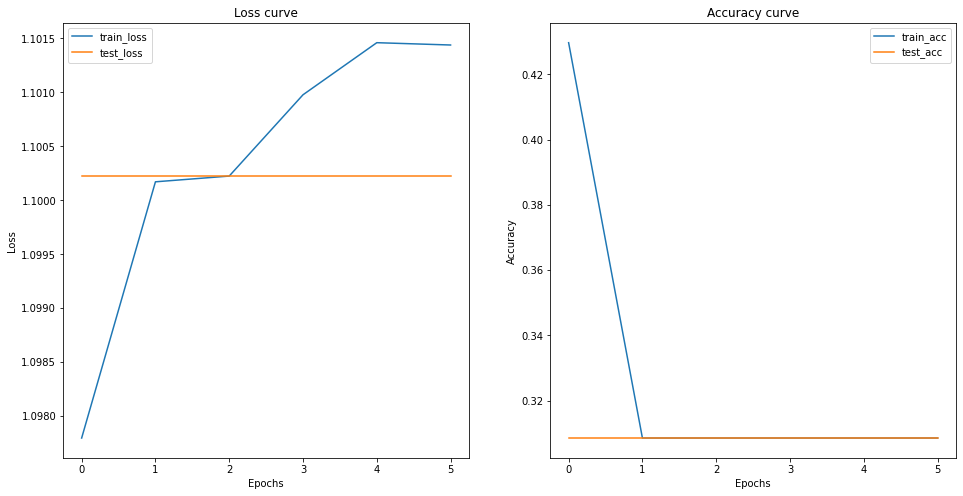

In [254]:
plot_loss_curves(model_v1_res)

## 10: Model_v2: TinyVGG with data augmentation


### 10.1 Create transform with data augmentation

In [255]:
from torchvision import transforms
train_transformer_trivial = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

### 10.2 Create train and test Dataset's and DataLoader's with data aumentation

In [256]:
# Image folders => dataset
from torchvision import datasets
train_data_aug = datasets.ImageFolder(root=train_dir,
                                      transform=train_transformer_trivial)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=test_transform_simple)

In [257]:
# Datasets into dataloaders

import os
from torch.utils.data import DataLoader
BATCH_SIZE = 32
N_WORKERS = os.cpu_count()

torch.manual_seed(10)
train_dataloader_augmented = DataLoader(dataset=train_data_aug,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=N_WORKERS)

test_dataloader_augmented = DataLoader(dataset=test_data_simple,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False,
                                       num_workers=N_WORKERS)

### 9.3 Contruct and train model version 2

In [258]:
# Create model_v2 
torch.manual_seed(10)
model_v2 = TinyVGG_v1(input_shape=3,
                      hidden_lay=10,
                      output_shape=len(train_data_aug.classes)).to(device)

model_v2

TinyVGG_v1(
  (conv_layer1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

#### Train the model

In [259]:
torch.manual_seed(10)
torch.cuda.manual_seed(10)

# Set epochs
NUM_EPOCHS = 6

# Setup loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_v2.parameters(),
                             lr=0.001)

# Start the timer
from timeit import default_timer as timer

start_training_time = timer()

model_v2_res = train(model=model_v2,
                     train_dataloader=train_dataloader_augmented,
                     test_dataloader=test_dataloader_simple,
                     optimizer=optimizer,
                     loss_fn=loss_fn,
                     epochs=NUM_EPOCHS,
                     device=device)

finish_train_timer = timer()

print(f"Train time: {finish_train_timer - start_training_time}")

  0%|          | 0/6 [00:00<?, ?it/s]

Epochs: 0 | Train loss: 1.097104 | Train acc: 0.425781 | Test loss: 1.1002
Epochs: 1 | Train loss: 1.101212 | Train acc: 0.308594 | Test loss: 1.1002
Epochs: 2 | Train loss: 1.097312 | Train acc: 0.429688 | Test loss: 1.1002
Epochs: 3 | Train loss: 1.098365 | Train acc: 0.304688 | Test loss: 1.1002
Epochs: 4 | Train loss: 1.097082 | Train acc: 0.429688 | Test loss: 1.1002
Epochs: 5 | Train loss: 1.100709 | Train acc: 0.308594 | Test loss: 1.1002
Train time: 14.318337556999722


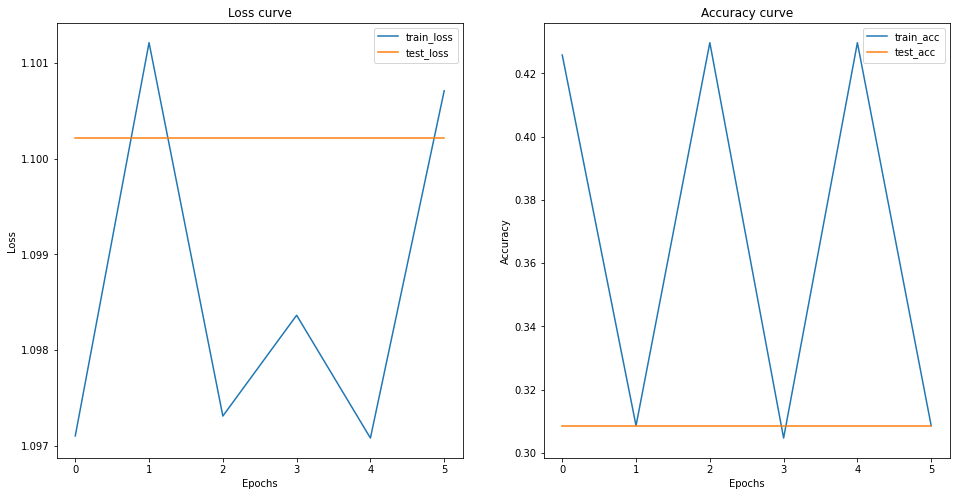

In [260]:
plot_loss_curves(model_v2_res)

1. Hardcoding
2. Pytorch + Tensorboard
3. Weights & Biases
4. MLFlow

In [261]:
import pandas as pd

model_v1_df = pd.DataFrame(model_v1_res)
model_v2_df = pd.DataFrame(model_v2_res)
model_v2_df

,train_loss,train_acc,test_loss,test_acc
0,1.097104,0.425781,1.10022,0.308594
1,1.101212,0.308594,1.10022,0.308594
2,1.097312,0.429688,1.10022,0.308594
3,1.098365,0.304688,1.10022,0.308594
4,1.097082,0.429688,1.10022,0.308594
5,1.100709,0.308594,1.10022,0.308594


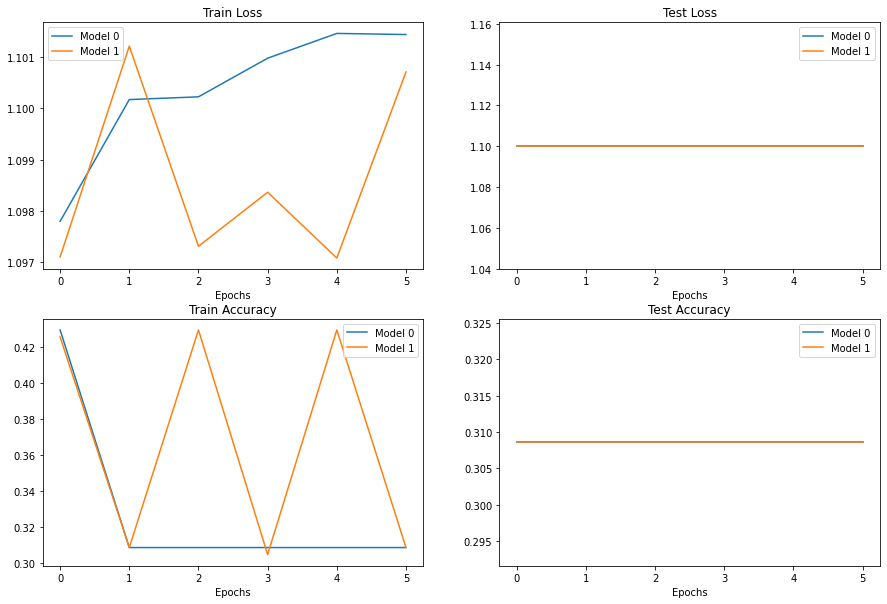

In [262]:
# Setup a plot 
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_v1_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_v1_df["train_loss"], label="Model 0")
plt.plot(epochs, model_v2_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_v1_df["test_loss"], label="Model 0")
plt.plot(epochs, model_v2_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_v1_df["train_acc"], label="Model 0")
plt.plot(epochs, model_v2_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_v1_df["test_acc"], label="Model 0")
plt.plot(epochs, model_v2_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

## 11. Making prediction on a custom image


In [263]:
# Download image
import requests

# Setup custom image path
custom_img_path = data_path / "04-pizza-dad.jpeg"

# Download image
if not custom_img_path.is_file():
  with open(custom_img_path, "wb") as f:
    # When downloading from GitHub
    req = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    f.write(req.content)
    print("Downloaded")
else: 
  print(f"{custom_img_path} exists")


Downloaded


### 11.1 Loading cutom image with PyTorch

* In Tensor form with datatype (torch.float32)
* Of shape 64x64x3
* On the right device

In [264]:
import torchvision

# Read in custom image
custom_img_uint8 = torchvision.io.read_image(str(custom_img_path))
custom_img_uint8

tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

In [266]:
print(f"Custom image shape: {custom_img_uint8.shape}\nCustom image type: {custom_img_uint8.dtype}")

Custom image shape: torch.Size([3, 4032, 3024])
Custom image type: torch.uint8
